<a href="https://colab.research.google.com/github/panzershracker/Python-for-DS2/blob/master/DS_2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install catboost

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from matplotlib import pyplot as plt
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import xgboost, lightgbm, catboost

import warnings

warnings.simplefilter('ignore')

In [1192]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/Python for DS 2/course_project_train.csv')

In [0]:
annot = ['домовладение','годовой доход','количество лет на текущем месте работы','налоговые льготы','количество открытых счетов',
         'количество лет кредитной истории','наибольший открытый кредит','количество проблем с кредитом','количество месяцев с последней просрочки платежа',
         'банкротства','цель кредита','срок кредита','текущая сумма кредита','текущий кредитный баланс','ежемесячный долг','кредитный рейтинг',
         'факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка',]

In [1195]:
for i in range(0, len(df.columns)):
    print(f'{i} - {df.columns[i]} - {annot[i]}')

0 - Home Ownership - домовладение
1 - Annual Income - годовой доход
2 - Years in current job - количество лет на текущем месте работы
3 - Tax Liens - налоговые льготы
4 - Number of Open Accounts - количество открытых счетов
5 - Years of Credit History - количество лет кредитной истории
6 - Maximum Open Credit - наибольший открытый кредит
7 - Number of Credit Problems - количество проблем с кредитом
8 - Months since last delinquent - количество месяцев с последней просрочки платежа
9 - Bankruptcies - банкротства
10 - Purpose - цель кредита
11 - Term - срок кредита
12 - Current Loan Amount - текущая сумма кредита
13 - Current Credit Balance - текущий кредитный баланс
14 - Monthly Debt - ежемесячный долг
15 - Credit Score - кредитный рейтинг
16 - Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка


In [0]:
# Неудобно писать название колонки каждый раз - введем селектор по индексу:

def col(col_index):
  return df.columns[col_index]

In [0]:
df = df.dropna(subset=[col(1), col(15)])

In [0]:
# df[(df[col(1)].isna() == True) & (df[col(15)].isna() == True)].dropna(axis=0)

In [1199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 17 columns):
Home Ownership                  5943 non-null object
Annual Income                   5943 non-null float64
Years in current job            5647 non-null object
Tax Liens                       5943 non-null float64
Number of Open Accounts         5943 non-null float64
Years of Credit History         5943 non-null float64
Maximum Open Credit             5943 non-null float64
Number of Credit Problems       5943 non-null float64
Months since last delinquent    2736 non-null float64
Bankruptcies                    5931 non-null float64
Purpose                         5943 non-null object
Term                            5943 non-null object
Current Loan Amount             5943 non-null float64
Current Credit Balance          5943 non-null float64
Monthly Debt                    5943 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  5

In [0]:
def balance(df, target):
  
  target_counts = df[target].value_counts()
  
  major = target_counts.argmax()
  minor = target_counts.argmin()
  
  disbalance_coef = target_counts[major] - target_counts[minor]
  
  for i in range(0, disbalance_coef):
    sample = df[df[target] == minor].sample()
    df = df.append(sample, ignore_index=True)
  
  return df.sample(frac=1)
  

In [0]:
def dummies_for_many(col_list, df=df):
  
  for i in col_list:
    
    dummy = pd.get_dummies(df[i])

    df = pd.concat([df, dummy], axis=1)

    df = df.drop(i, axis=1)

  return df

In [0]:
def report():
  
  print(f'TRAIN \n {classification_report(y_train, y_train_pred)}\n')
  print(f'TEST \n {classification_report(y_test, y_test_pred)}')

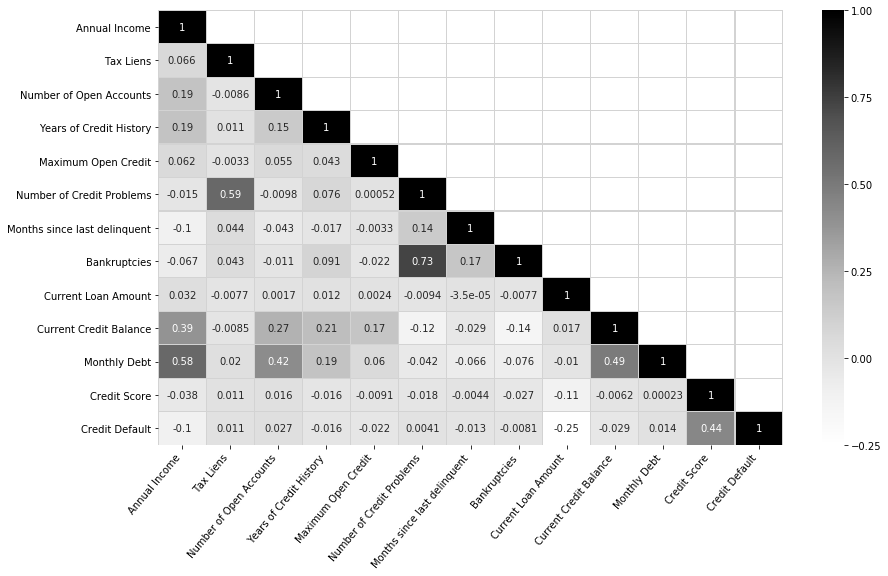

In [1203]:
corr = df.corr()

mask = np.triu(corr, k=1)

rcParams['figure.figsize'] = 14, 8

sns.heatmap(corr, mask=mask, linewidths=.2, linecolor='lightgrey', cmap='Greys', annot=True)

plt.xticks(rotation=50, horizontalalignment='right')

plt.show()

### 'Months since last delinquent' filling

По логике, если у клиента не было проблем с кредитом, то и просрочек у него не было, и те  nan-значения признака "Months since last delinquent" где "Number of Credit Problems" = 0, заменить на медиану ненулевых значений.

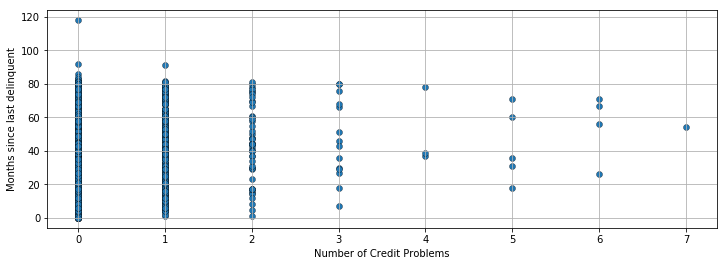

In [1204]:
rcParams['figure.figsize'] = 12, 4

plt.scatter(df[col(7)], df[col(8)], edgecolor='black', linewidths=.3)

plt.xlabel(col(7))
plt.ylabel(col(8))

plt.grid()
plt.show()

In [0]:
med = df.loc[(df[col(8)].isna() == False), col(8)].median()

df.loc[(df[col(8)].isna() == True) & (df[col(7)] == 0), col(8)] = med

Заполним оставшиеся значения  "Months since last delinquent", заполнив их медианой по показателям с тем же значением по "Number of Credit Problems"

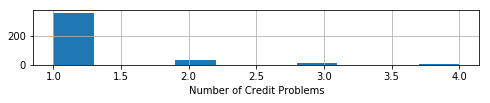

In [1206]:
rcParams['figure.figsize'] = 8, 1

plt.hist(df.loc[df[col(8)].isna() == True, col(7)])

plt.grid()
plt.xlabel(col(7))
plt.show()

In [0]:
min_ = df.loc[(df[col(7)] == 1) & (df[col(8)].isna() == False), col(8)].min()

df.loc[(df[col(8)].isna() == True) & (df[col(7)] == 1), col(8)] = min_

In [0]:
med = df.loc[(df[col(7)] == 2) & (df[col(8)].isna() == False), col(8)].median()

df.loc[(df[col(8)].isna() == True) & (df[col(7)] == 2), col(8)] = med

In [0]:
med = df.loc[(df[col(7)] == 3) & (df[col(8)].isna() == False), col(8)].median()

df.loc[(df[col(8)].isna() == True) & (df[col(7)] == 3), col(8)] = med

In [0]:
med = df.loc[(df[col(7)] == 4) & (df[col(8)].isna() == False), col(8)].median()

df.loc[(df[col(8)].isna() == True) & (df[col(7)] == 4), col(8)] = med

### 'Bankruptcies' Filling

In [1211]:
col(9), col(7)

('Bankruptcies', 'Number of Credit Problems')

In [1212]:
# Кол-во пропусков по 'Bankruptcies'.
# Тут мы видим, что пропуски по 'Bankruptcies' имеют 0 в 'Number of Credit Problems',
# значит меняем NaN в 'Bankruptcies' на 0

len(df.loc[(df[col(9)].isna() == True) & (df[col(7)] == 0), col(9)])

12

In [0]:
# Т.к. Банкротства имеют высокий показатель корреляции с числом проблем с кредитом, 
# мы можем сделать вывод, что пропущенные значения равны нулю, если проблем с кредитом не было.

df.loc[df[col(9)].isna() == True] = df.loc[df[col(9)].isna() == True].fillna(0)

### Years in current job filling
У всех пропущенных значений 'Years in current job' ненулевые показатели 'Months since last delinquent'. Попробуем восстановить значения используя эту связь.

In [1214]:
col(2), col(8)

('Years in current job', 'Months since last delinquent')

In [0]:
# df.loc[(df[col(2)].isna() == True) & (df[col(8)] != 0), col(8)].value_counts().sort_index(ascending=False)

In [1216]:
df.loc[(df[col(2)].isna() == True) & (df[col(8)] != 0), col(8)].describe()

count    296.000000
mean      31.177365
std       18.957887
min        1.000000
25%       23.000000
50%       32.000000
75%       36.250000
max       92.000000
Name: Months since last delinquent, dtype: float64

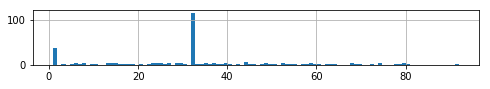

In [1217]:
plt.hist(df.loc[(df[col(2)].isna() == True) & (df[col(8)] != 0), col(8)], bins=100)

plt.grid()
plt.show()

In [0]:
df.loc[(df[col(8)].between(0, 93)) & (df[col(2)].isna() == True), col(2)] = '4 years'

In [1219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 17 columns):
Home Ownership                  5943 non-null object
Annual Income                   5943 non-null float64
Years in current job            5943 non-null object
Tax Liens                       5943 non-null float64
Number of Open Accounts         5943 non-null float64
Years of Credit History         5943 non-null float64
Maximum Open Credit             5943 non-null float64
Number of Credit Problems       5943 non-null float64
Months since last delinquent    5943 non-null float64
Bankruptcies                    5943 non-null float64
Purpose                         5943 non-null object
Term                            5943 non-null object
Current Loan Amount             5943 non-null float64
Current Credit Balance          5943 non-null float64
Monthly Debt                    5943 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  5

In [1220]:
# Балансировка целевой переменной

df = balance(df, col(16))

df[col(16)].value_counts()

1    4359
0    4359
Name: Credit Default, dtype: int64

In [0]:
#  Разделение категориальных и числовых признаков

TARGET_col = col(16)
CAT_cols = col([0,2,10,11])
NUM_cols = df[df.columns.difference(CAT_cols)].drop(TARGET_col, axis=1).columns

In [0]:
# Разрежение категориальных признаков (дамми переменные)

df_sparse = dummies_for_many(CAT_cols)


# XGBoost не позволяет работать с признаками в названии которых "<", поэтому: 
df_sparse = df_sparse.rename(columns={'< 1 year':'less 1 year'})

In [1223]:
df_sparse.head(1)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,less 1 year,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,small business,take a trip,vacation,wedding,Long Term,Short Term
0,482087.0,0.0,11.0,26.3,685960.0,1.0,1.0,1.0,99999999.0,47386.0,7914.0,749.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
# Стандартизируем числовые признаки

scaler = StandardScaler()

df_sparse[NUM_cols] = scaler.fit_transform(df_sparse[NUM_cols], TARGET_col)

In [1225]:
df_sparse.head(2)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,less 1 year,business loan,buy a car,buy house,debt consolidation,educational expenses,home improvements,major purchase,medical bills,moving,other,small business,take a trip,vacation,wedding,Long Term,Short Term
0,-1.046183,-0.108731,-0.025608,1.134146,-0.018956,1.666800,-1.823069,2.507673,2.414726,-0.757956,-0.872080,-0.250629,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.403310,-0.108731,0.790402,-0.427729,0.061582,-0.340453,0.032748,-0.334803,-0.415438,0.324280,0.007938,-0.258108,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
# train test split


# X = df_sparse[df_sparse.columns.difference(list(TARGET_col))]
X = df_sparse.loc[:, df_sparse.columns != TARGET_col]
y = df_sparse[TARGET_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.25, random_state=21)

# Построение моделей

In [1227]:
# XGBoost

xgb = xgboost.XGBClassifier(random_state=21)

xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

report()

TRAIN 
               precision    recall  f1-score   support

           0       0.80      0.99      0.89      3262
           1       0.94      0.32      0.48      1195

    accuracy                           0.81      4457
   macro avg       0.87      0.66      0.68      4457
weighted avg       0.84      0.81      0.78      4457


TEST 
               precision    recall  f1-score   support

           0       0.80      0.99      0.88      1097
           1       0.91      0.30      0.45       389

    accuracy                           0.81      1486
   macro avg       0.86      0.65      0.67      1486
weighted avg       0.83      0.81      0.77      1486



In [1228]:
# lightGBM

lgbm = lightgbm.LGBMClassifier(random_state=21)

lgbm.fit(X_train, y_train)

y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)

report()

TRAIN 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      3262
           1       1.00      0.78      0.88      1195

    accuracy                           0.94      4457
   macro avg       0.96      0.89      0.92      4457
weighted avg       0.95      0.94      0.94      4457


TEST 
               precision    recall  f1-score   support

           0       0.81      0.95      0.87      1097
           1       0.71      0.35      0.47       389

    accuracy                           0.79      1486
   macro avg       0.76      0.65      0.67      1486
weighted avg       0.78      0.79      0.77      1486



In [1229]:
# CatBoost

catb = catboost.CatBoostClassifier(silent=True, random_state=21)

catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)

report()

TRAIN 
               precision    recall  f1-score   support

           0       0.83      1.00      0.90      3262
           1       0.97      0.43      0.60      1195

    accuracy                           0.84      4457
   macro avg       0.90      0.71      0.75      4457
weighted avg       0.87      0.84      0.82      4457


TEST 
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      1097
           1       0.86      0.32      0.47       389

    accuracy                           0.81      1486
   macro avg       0.83      0.65      0.68      1486
weighted avg       0.82      0.81      0.77      1486



# TODO Сделать обработку и для ТЕСТА, так же добавить кросс-валидацию.
## Понять почему низки recall
### Подозреваю что плохая обобщенность модели для класса = 1 свзяана с частым повторением одинаковых наблюдений из-за баллансировки. Попробовать предикт кредитного рейтинга и на его основе таргета. Так же проверить наиболее значимые признаки.

In [1232]:
# KNN

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

report()

TRAIN 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      3262
           1       0.82      0.47      0.60      1195

    accuracy                           0.83      4457
   macro avg       0.83      0.72      0.75      4457
weighted avg       0.83      0.83      0.81      4457


TEST 
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      1097
           1       0.64      0.35      0.45       389

    accuracy                           0.78      1486
   macro avg       0.72      0.64      0.66      1486
weighted avg       0.76      0.78      0.75      1486



In [1233]:
# # logistic regression

lr = LogisticRegression()

lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

report()

TRAIN 
               precision    recall  f1-score   support

           0       0.79      0.98      0.88      3262
           1       0.87      0.30      0.45      1195

    accuracy                           0.80      4457
   macro avg       0.83      0.64      0.66      4457
weighted avg       0.81      0.80      0.76      4457


TEST 
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      1097
           1       0.82      0.30      0.43       389

    accuracy                           0.80      1486
   macro avg       0.81      0.64      0.66      1486
weighted avg       0.80      0.80      0.76      1486

